# Peeking Simulator

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.power import TTestIndPower
from scipy.stats import norm
import scipy.stats as stats

# One A/A Test

When conducting an A/A test, the variant is not different from the control. In the context of online A/B testing, traffic is split into two different pages (A & B) to see which version is better. In A/A tests, both version are exactly the same. This articule explores why would implement A/A tests in the first place: https://vwo.com/blog/aa-test-before-ab-testing/


Since both variants are the same though, we would not expect any variant to be "better" than the other. If correctly implemented, we should find one variant to be statistically different from the other, 5% of the time, as indicated by our alpha/false positive probability.

To make sure both variants are the same, I'll be drawing sample from the standard normal distirbution which has mean 0 and std 1. The plot below shows that both distributions come from the same population.




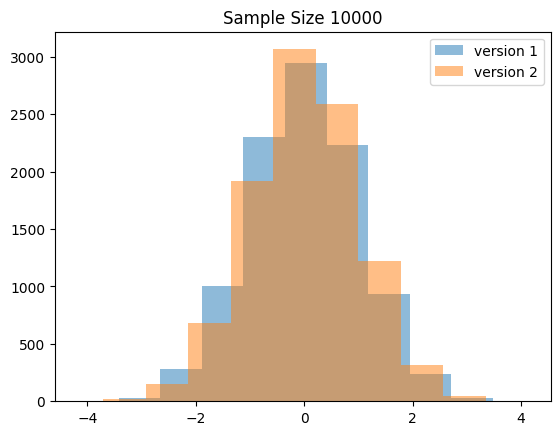

In [12]:
control = np.random.standard_normal(size=10000) 
treatment = np.random.standard_normal(size=10000) 
plt.hist(control, alpha=0.5, label='version 1')
plt.hist(treatment, alpha=0.5, label='version 2')
plt.title("Sample Size 10000")
plt.legend()
plt.show()

Now that we have our two variants for the A/A test, we will design our experiment to have a 5% false positive probability. That is, on average, if we were to run 100 identical experiments, 5 of them will have a p-value lower than alpha, indicating a statistical significant result.


Since we know they are not different, those conclusions would be wrong, but we would only make those wrong conclusion 5% of the time as designed by us. The problem with peeking is that the rate at which we make those wrong conclusions increases. Below is the intuition as to why:

-- 

The way we designed the experiment, and as indicated by the power analysis, if we collect a sample size of 10095 observations (this could be users, sessions, etc), we would have a false positive rate of 5%. **Peeking occurs when you make conclusions about the experiment before such sample size is collected.**

In [3]:
effect_size = 0.035
alpha = 0.05 # significance level, false positive probability
power = 0.8 # probability of correctly rejecting the null hypothesis

power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='larger')
print(f"Sample size per group: {sample_size:.0f}")

Sample size per group: 10095


The validity of the statement that you have a 5% False Positive probability as indicated by alpha comes from the fact that run the experiment all the way until you have collected all the necessary observations: 10095


**Example**

- we're testing a new color for a button in our company's landing page, and we have a fixed sample size of 10095 for each variant

**Peeking**
- We decide to **peek** on the results every 1000 customers that visit each variant, and stop the experiment the first time our p-value is below our 5% alpha threshold

**No Peeking**
- we wait until we have collected our full sample size before making any conclusions about the experiment.

In [4]:
point_estimate_lst = []
sample_lst = []
confidence_level_lst = []
p_value_lst = []

for n in range(3,round(sample_size)+3, 1000):
    control = np.random.standard_normal(size=n)
    treatment = np.random.standard_normal(size=n) 
    t_statistic, p_value = stats.ttest_ind(control, treatment)

    confidence_level_lst.append(1 - p_value)
    p_value_lst.append(p_value)
    sample_lst.append(n)

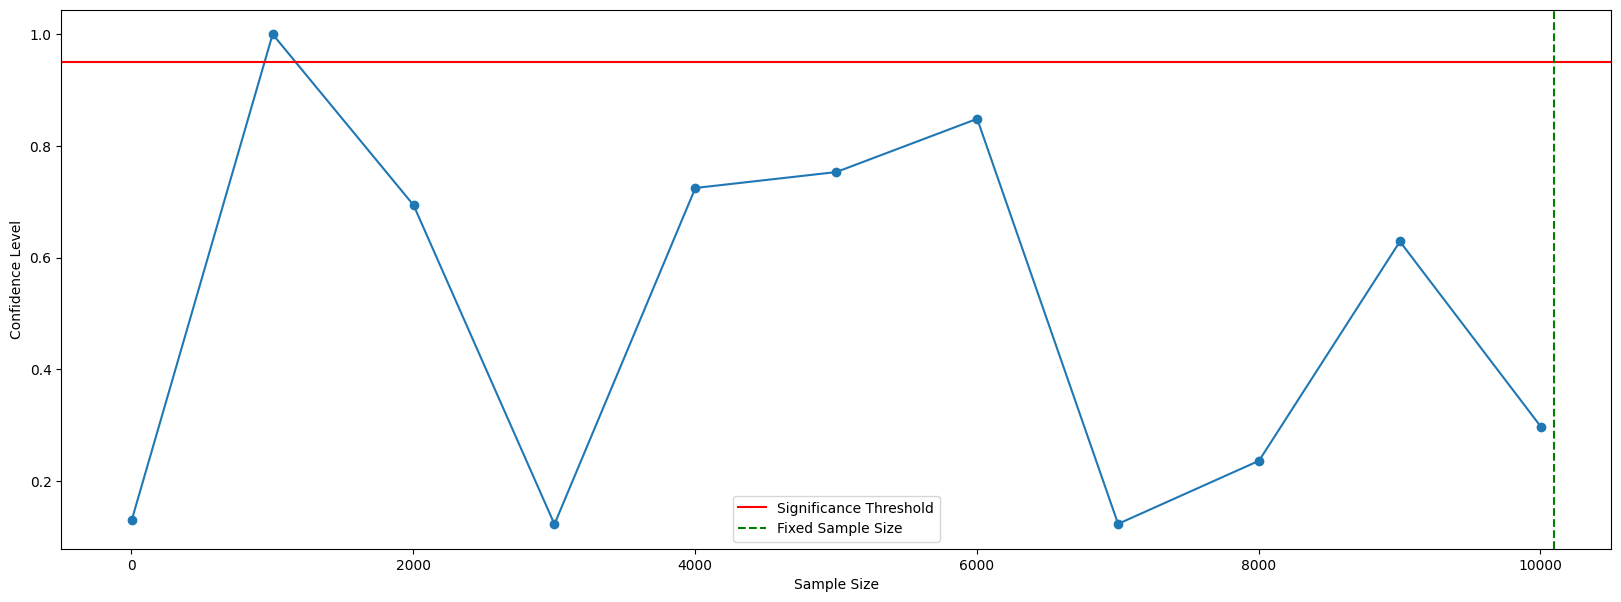

In [5]:
plt.figure(figsize=(20,7))
plt.plot(sample_lst,confidence_level_lst, marker='o')
plt.axhline(1-alpha, c='red', label='Significance Threshold')
plt.axvline(round(sample_size), c='green', label='Fixed Sample Size', ls='--')
plt.ylabel("Confidence Level")
plt.xlabel("Sample Size")
plt.legend()
plt.show()

### Single A/A Test. How is the Type 1 Error Inflated?


- In **Fixed Size Sample Testing**, you commit to how many observations you will collect (green dashed line) before evaluating your experiment. If you stop your experiment before the required sample size, you're peeking and therefore inflating your Type 1 error probability.

- The validity of the statement that you have a 5% False Positive probability as indicated by alpha comes from the fact that run the experiment all the way until the green dashed line. For example, If you were to run 100 A/A tests where you allow it to run all the way to the green dashed line, on average 5 of those will detect a difference, which is being above the red line (Type 1 error).

### Simulating 1000 A/A tests

I will keep track of 2 results for each of the 1000 tests:

1. Whether the test is significant, making conclusions with the full sample size (**no peeking**)
2. Whether the test is significant, stopping as soon as we have a significant result (**peeking**)


Since we know the truth, that A and B are not different, we should only expect **50** out of the 1000 tests to be significant

In [6]:
aa_tests = []
peeking_lst = []

for _ in range(1000): # 1000 A/A tests

    sample_lst = []
    confidence_level_lst = []
    p_value_lst = []

    for n in range(3,round(sample_size)+3, 1000):
        control = np.random.standard_normal(size=n)
        treatment = np.random.standard_normal(size=n) 
        t_statistic, p_value = stats.ttest_ind(control, treatment)

        confidence_level_lst.append(1 - p_value)
        p_value_lst.append(p_value)
        sample_lst.append(n)

    peeking_lst.append( any([1 if i < alpha else 0 for i in p_value_lst]) )
    aa_tests.append(p_value_lst[-1]<alpha)

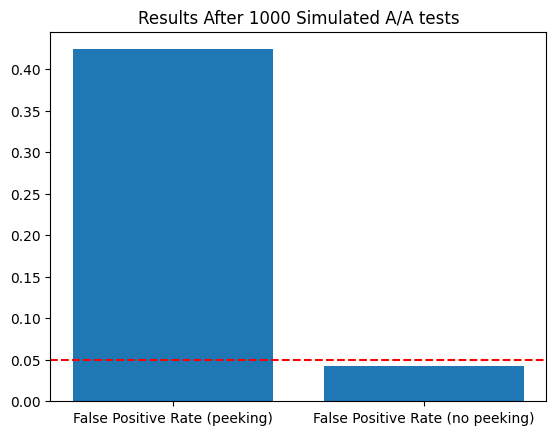

In [7]:
data = {"False Positive Rate (peeking)": sum(peeking_lst) / 1000, "False Positive Rate (no peeking)": sum(aa_tests) / 1000}

plt.bar(data.keys(), data.values())
plt.title("Results After 1000 Simulated A/A tests")
plt.axhline(alpha, c='red', label='Significance Level', ls='dashed')
plt.show()

-----

In [29]:

def aa_test_simulation(sample_size):
    aa_tests = []
    peeking_lst = []

    for _ in range(100): # running 100 A/A Tests

        point_estimate_lst = []
        sample_lst = []
        confidence_level_lst = []
        p_value_lst = []

        for n in range(3,round(sample_size)+3, int(np.floor(60002 / 10))):

            control = np.random.standard_normal(size=n)
            treatment = np.random.standard_normal(size=n) 
            point_estimate = (control - treatment).mean()
            
            pooled_se = pooled_standard_error(s1=control.std(), s2=treatment.std(), n1=n, n2=n)
            z = point_estimate / pooled_se
            p_value = z_to_p_value(z, two_tailed=False)

            confidence_level_lst.append(1 - p_value)
            p_value_lst.append(p_value)
            point_estimate_lst.append(point_estimate)
            sample_lst.append(n)

        peeking_lst.append( any([1 if i < alpha else 0 for i in p_value_lst]) )
        aa_tests.append(p_value_lst[-1]<alpha)

    return sum(peeking_lst)/100, sum(aa_tests)/100

    

In [30]:
sample_size=[i for i in range(2,61000+2, 3000)]
peeking_lst = []
aa_test_lst = []

for sample in sample_size:
    peeking, aa_test = aa_test_simulation(sample_size=sample)
    peeking_lst.append(peeking)
    aa_test_lst.append(aa_test)


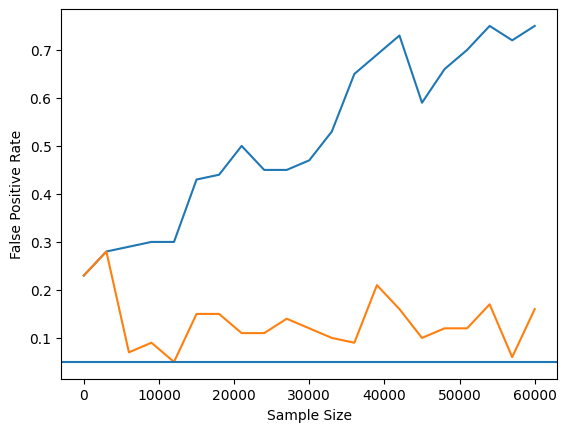

In [31]:
plt.plot(sample_size,peeking_lst)
plt.plot(sample_size,aa_test_lst)
plt.ylabel("False Positive Rate")
plt.xlabel("Sample Size")
plt.axhline(alpha, label='Prestablished Alpha')
plt.show()


Test

In [4]:
effect_sizes = [0.08, 0.05, 0.04, 0.035, 0.029]

alpha = 0.05 # significance level, false positive probability
power = 0.8 # probability of correctly rejecting the null hypothesis

for effect_size in effect_sizes:
    power_analysis = TTestIndPower()
    sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='larger')
    print(round(sample_size))
    # print(f"Sample size per group: {sample_size:.0f}")

1933
4947
7729
10095
14704


# Sequential Testing

In [120]:
n_lst = []
mean_lst = []
std_error_lst = []
std_error_log_lst = []

for n in range(10,10000, 1):
    mean  = np.random.standard_normal(size=n).mean()
    n_lst.append(n)
    mean_lst.append(mean)
    std_error_lst.append(1/np.sqrt(n))
    std_error_log_lst.append(np.sqrt(np.log(n)/n))

Text(0, 0.5, 'Sample Mean')

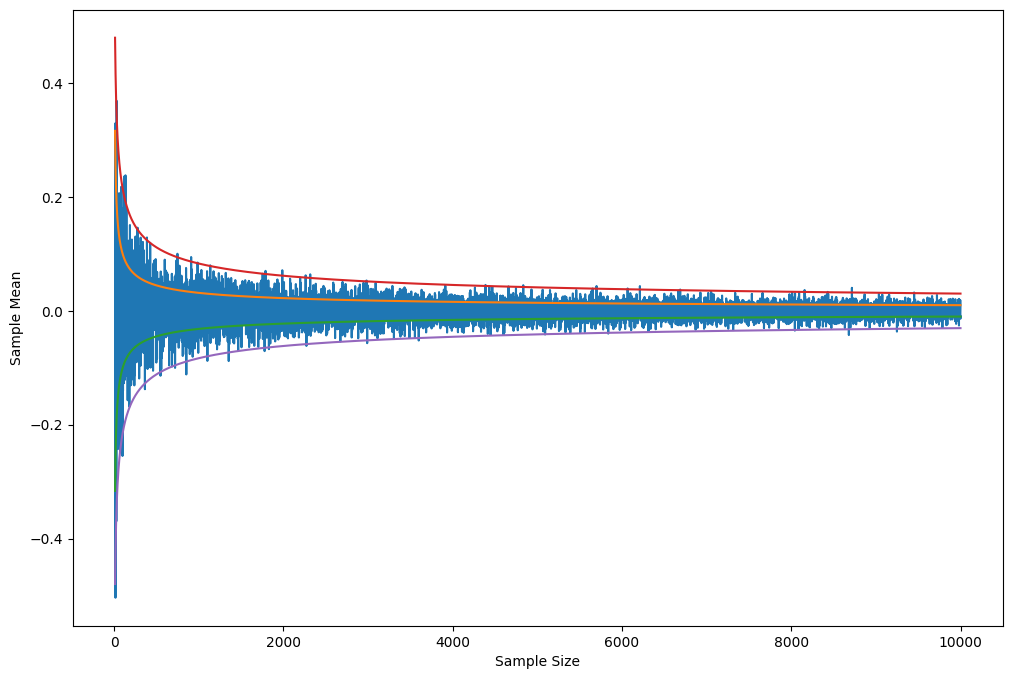

In [121]:
plt.figure(figsize=(12,8))
plt.plot(n_lst, mean_lst)
plt.plot(n_lst, std_error_lst)
plt.plot(n_lst, [-1*i for i in std_error_lst])

plt.plot(n_lst, std_error_log_lst)
plt.plot(n_lst, [-1*i for i in std_error_log_lst])
plt.xlabel("Sample Size")
plt.ylabel("Sample Mean")

---